Для корректной работы ноутбука загрузите файл Gold.xlsx в сессионное хранилище

Для обучения временного ряда использовалась библиотека Etna, разработанная командой тинькофф. Подробнее [тут](https://etna-docs.netlify.app/)

In [ ]:
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.3/304.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from etna.datasets import TSDataset
from etna.analysis import stl_plot

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [ ]:
df = pd.read_excel('Gold.xlsx')

In [ ]:
df["timestamp"] = pd.to_datetime(df["Дата"])
df["target"] = df["Значение"]
df.drop(columns=["Дата", "Значение"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2023-05-23,1969.2,main
1,2023-05-22,1970.3,main
2,2023-05-19,1961.6,main
3,2023-05-18,1960.3,main
4,2023-05-17,1974.4,main


In [ ]:
df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2013-05-23,1380.50
2013-05-24,1390.25
2013-05-28,1376.50
2013-05-29,1382.50
2013-05-30,1413.50


Создаем объект класса TSDataset для обучения ряда

In [ ]:
ts = TSDataset(df, freq="D")

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:145: UserWarning: You probably set wrong freq. Discovered freq in you data is None, you set D
  warnings.warn(


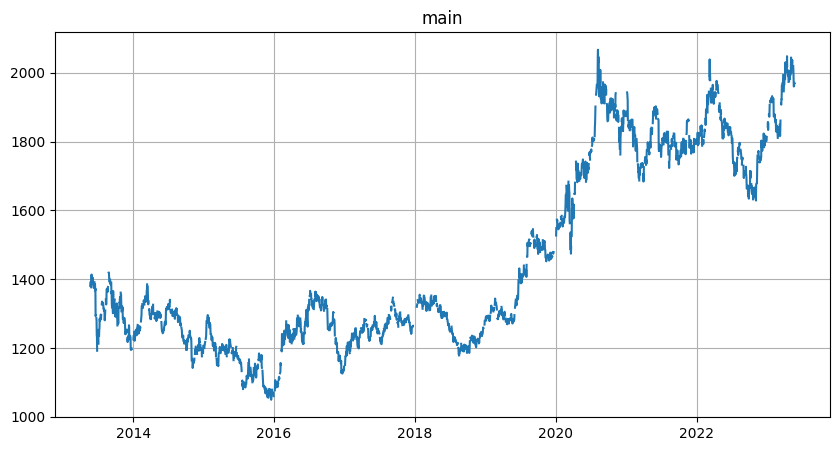

In [ ]:
ts.plot()

In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2013-05-23,2023-05-23,3653,1152,1,0,0,0,D


Видим, что у нас много пропусков(num_missing). Давайте попробуем понять, есть ли какая-то зависимость в отсутствии данных. Проверим дни недели

In [ ]:
tr = ts.to_pandas()
tr.head()

segment,main
feature,target
timestamp,
2013-05-23,1380.50
2013-05-24,1390.25
2013-05-25,NaN
2013-05-26,NaN
2013-05-27,NaN


In [ ]:
tr.columns = [tup[1] if tup[1] else tup[0] for tup in tr.columns]

In [ ]:
tr.reset_index(inplace=True)

In [ ]:
tr['week_day'] = tr['timestamp'].dt.day_name()
tr.groupby('week_day').count()

,timestamp,target
week_day,,
Friday,522,497
Monday,522,468
Saturday,522,1
Sunday,522,1
Thursday,522,510
Tuesday,522,511
Wednesday,521,513


Данных нет по выходным дням. Надо понять бизнесовый смысл их отсутствия. Пока заполним пропуски через скользящее среднее

Также посмотрим на боксплот

<Axes: xlabel='week_day', ylabel='target'>

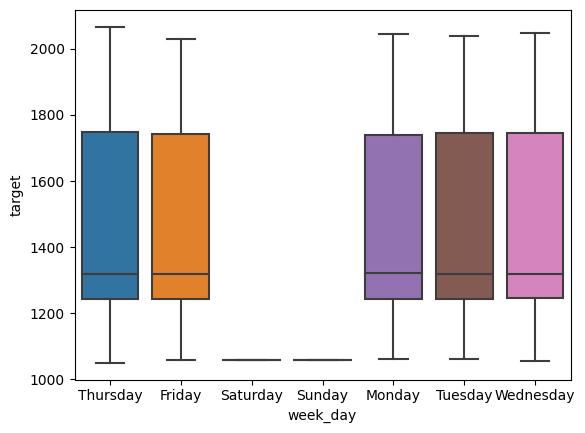

In [ ]:
sns.boxplot(data = tr, x = 'week_day', y = 'target')

Уберем пропущенные значения, заполняя их скользящим средним с окном 30, с помощью метода TimeSeriesImputerTransform.

In [ ]:
from etna.transforms import TimeSeriesImputerTransform

In [ ]:
missing = TimeSeriesImputerTransform(strategy="running_mean", window=30)
ts.fit_transform([missing])
ts.describe()

/usr/local/lib/python3.10/dist-packages/etna/transforms/missing_values/imputation.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i] = np.nanmean(df.iloc[indexes])


,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2013-05-23,2023-05-23,3653,0,1,0,0,0,D


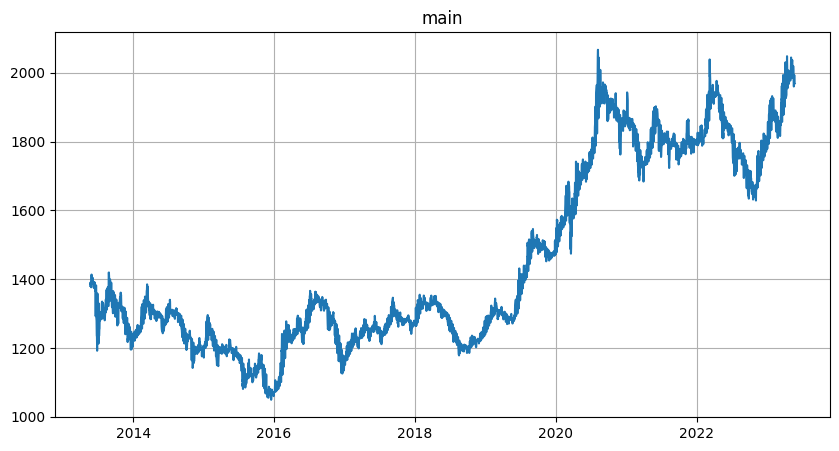

In [ ]:
ts.plot()

Теперь посмотрим на STL разложение, оно выявляет тренд и сезонность. Поле period - это период сезонность в днях. Ниже поиграемся с ним, чтобы увидеть различные паттерны

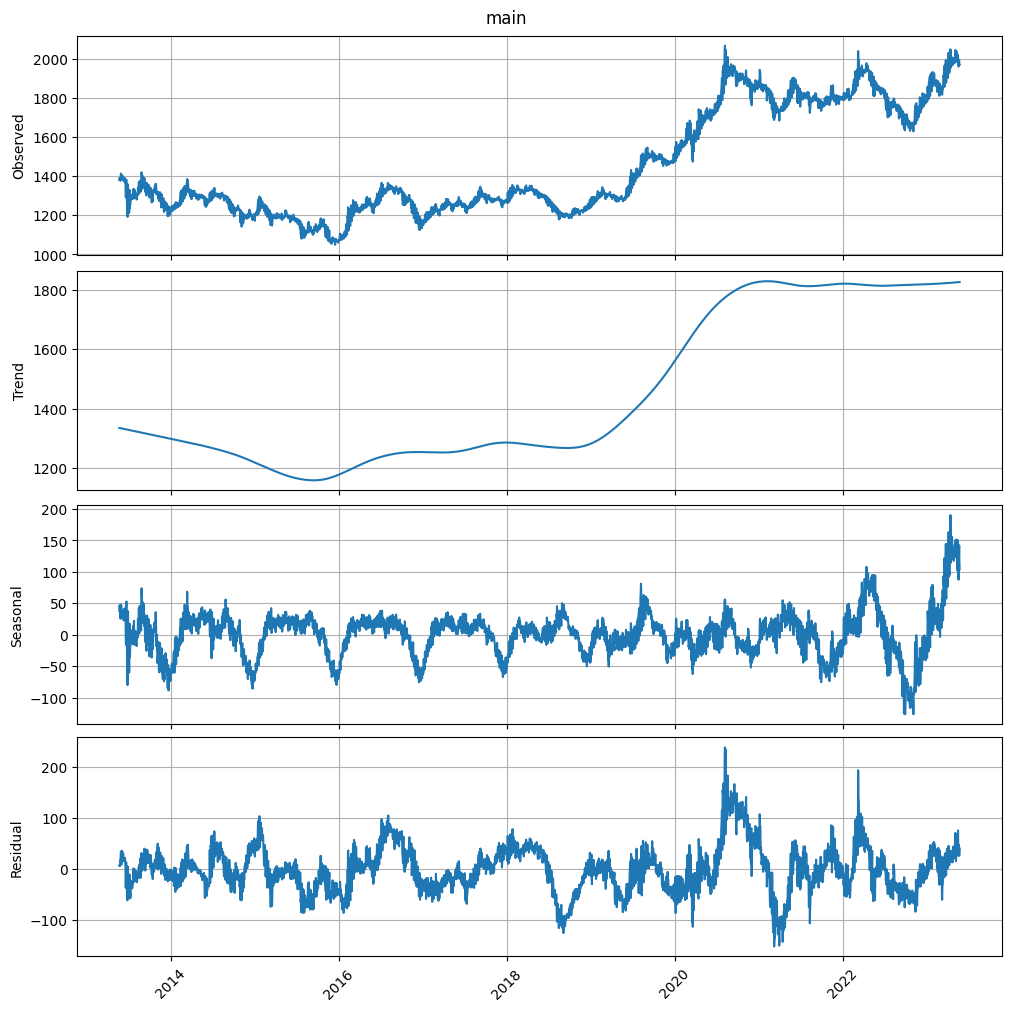

In [ ]:
stl_plot(ts=ts, period=365)

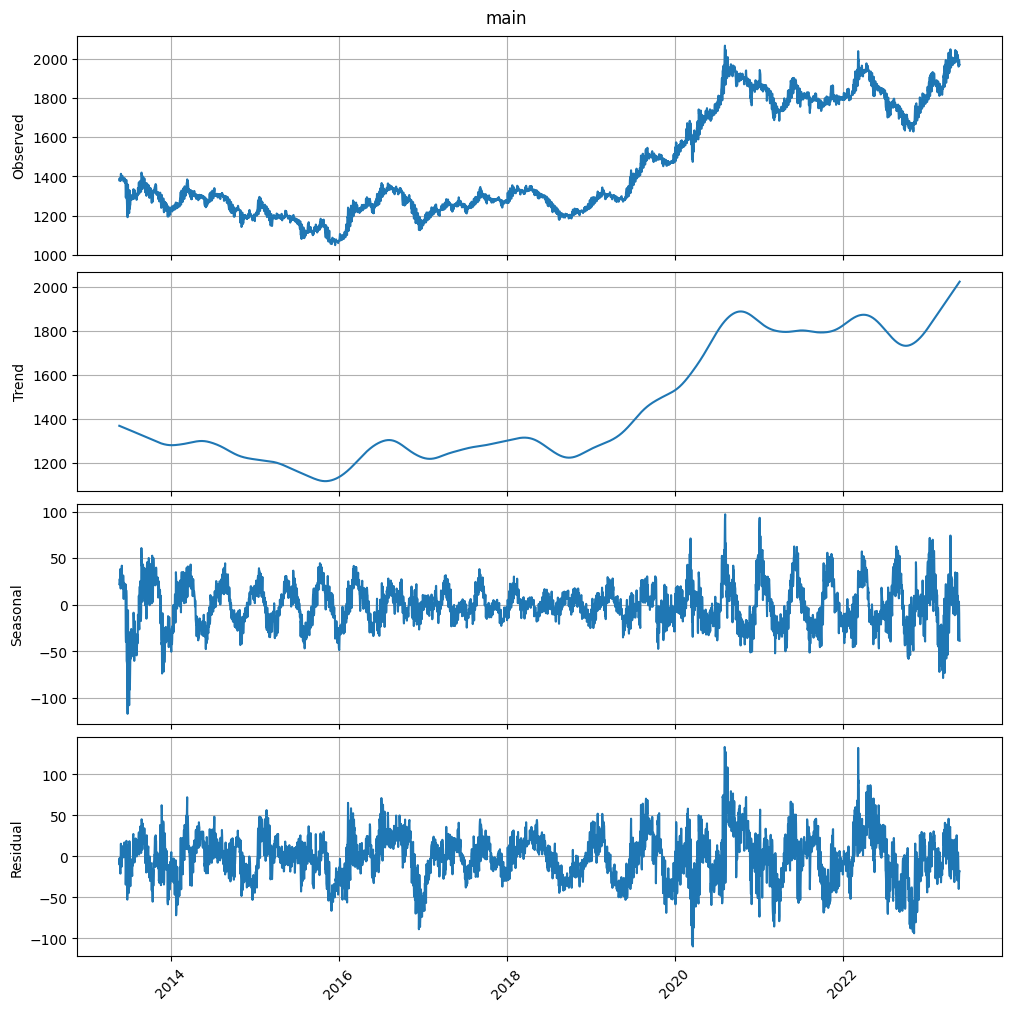

In [ ]:
stl_plot(ts=ts, period=150)

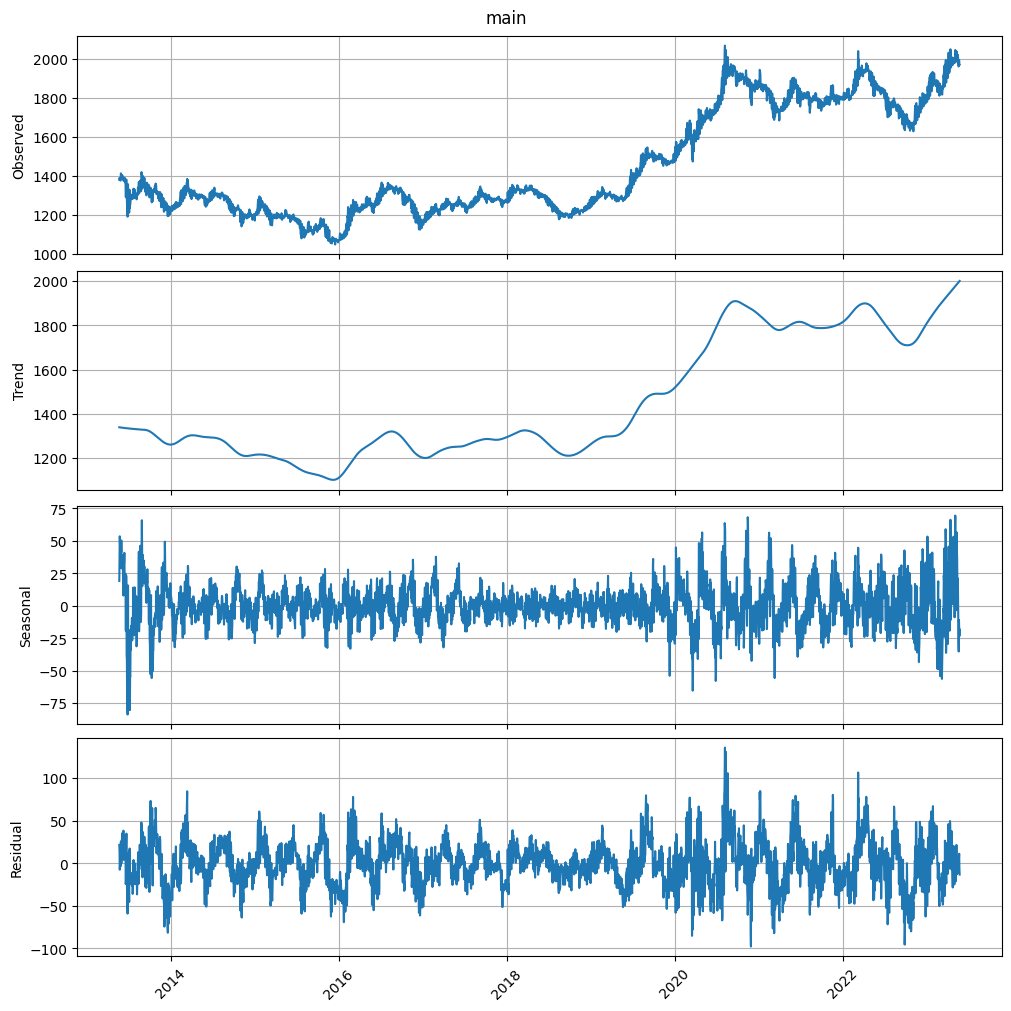

In [ ]:
stl_plot(ts=ts, period=100)

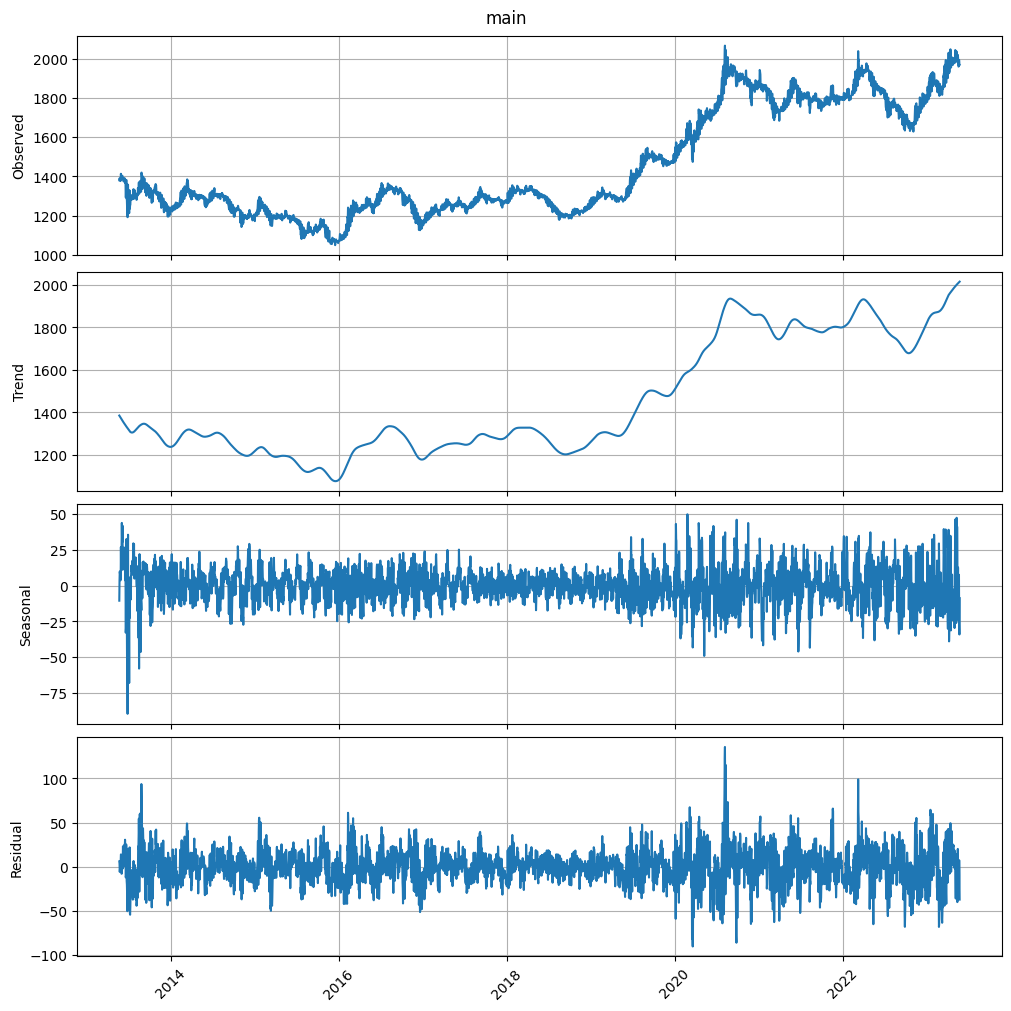

In [ ]:
stl_plot(ts=ts, period=50)

Так, теперь посмотрим на выбросы (нестандартные вспелески). Обычно, они удаляются, чтобы нормально работать с рядом, но вдруг это те всплески, которые запредиктить надо.

Поэтому просто посомтрим на них и попытаемся понять, с чем могут быть связаны данные аутлаеры

In [ ]:
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)

from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           acf_plot)

Сейчас будет интерактивный графичек, в котором выброс считается на основе медианы. Вы можете задать размер окна, в рамках которого считается медиана и коффициент альфа - отклонение, которое детектит выброс

In [ ]:
method = get_anomalies_median
params_bounds = {"window_size": (40, 100, 1), "alpha": (0.1, 4, 0.25)}
plot_anomalies_interactive(
    ts=ts, segment='main', method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', min=40, style=Sl…

а еще посмотрим на Автокорреляцию

>Функция автокорреляции (АКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов, считая значения интервалов в промежутке.

По графику ACF можно определить необходимую величину лага для моделей скользящего среднего


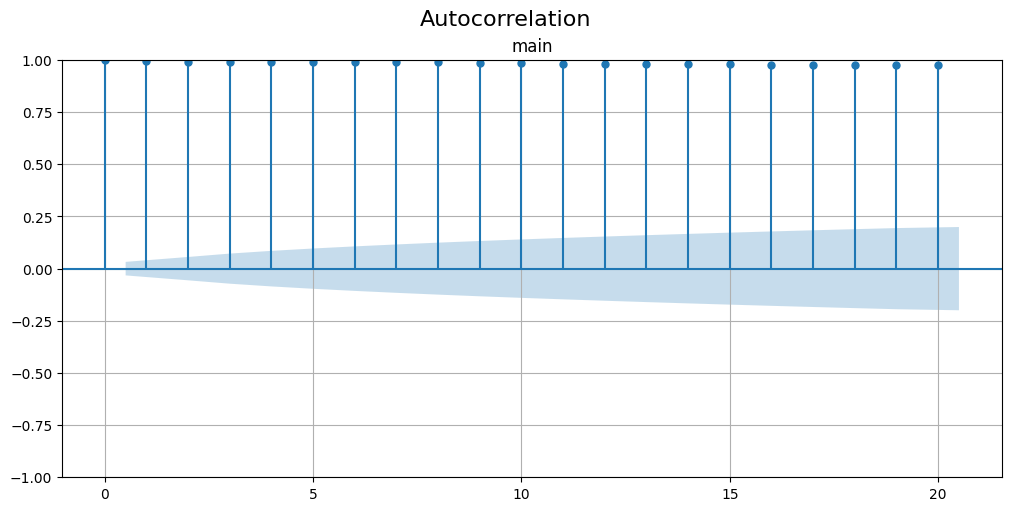

In [ ]:
acf_plot(ts, lags=20)

Как-то не особо информативненько получилось. Корреляция везде высокая. Возьмем частную автокорреляцию

>Функция частной автокорреляции (ЧАКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов.

По графику PACF можно определить необходимую величину лага для авторегрессионных моделей

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


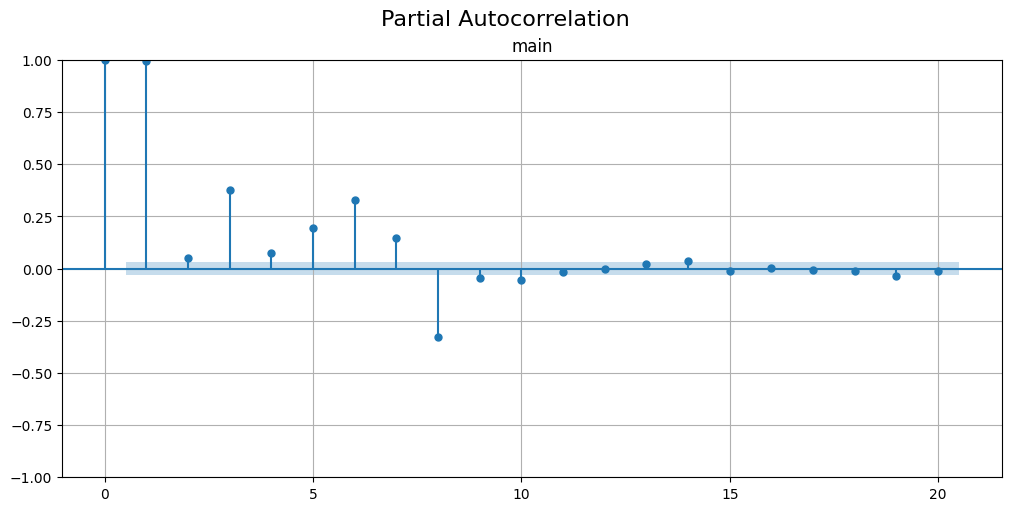

In [ ]:
acf_plot(ts, lags=20, partial=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


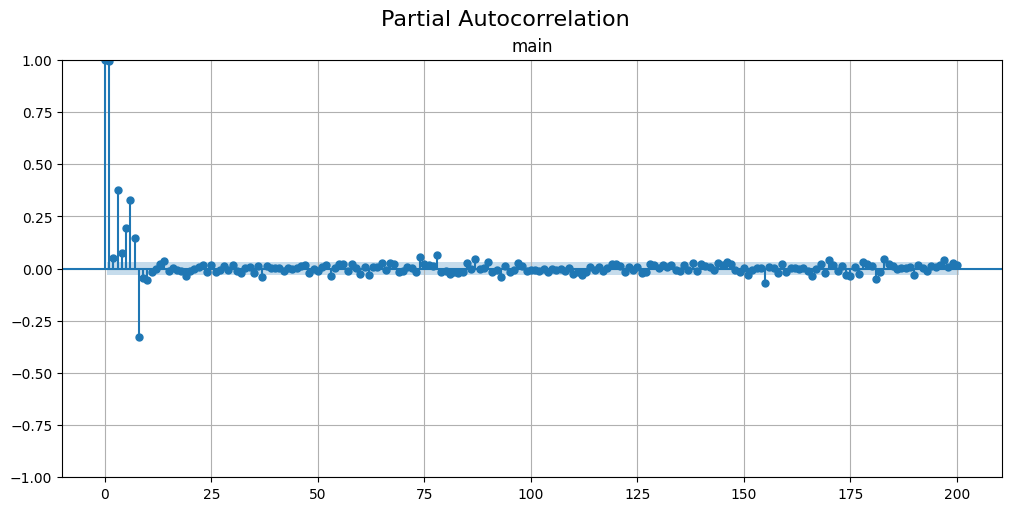

In [ ]:
acf_plot(ts, lags=200, partial=True)

Кажется, в качестве лага достаточно брать 10 предыдущих значений. Грустно, конечно, что никакой сезонности не наблюдается.

Построим предсказание

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2013-05-23    2023-05-23    3653            0


In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2013-05-23",
    train_end="2022-12-31",
    test_start="2023-01-01",
    test_end="2023-05-23",
)

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines

from etna.models import (CatBoostPerSegmentModel, CatBoostMultiSegmentModel,
                         LinearPerSegmentModel, MovingAverageModel, NaiveModel,
                         ProphetModel, SeasonalMovingAverageModel, AutoARIMAModel)

from etna.metrics import MAE, MAPE, MSE, SMAPE

from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                              STLTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)

In [ ]:
HORIZON = 151 # прогнозируем на 5 месяцев вперед (с 1 января по 23 мая)
NUMBER_OF_LAGS = 10
HISTORY_LEN = 5 * HORIZON


`AutoRegressivePipeline` это пайплайн, который итеративно строит предсказание на `step` шагов вперед, после чего использует предсказанные значения как признаки для следующих шагов.

Плюсы:
* Позволяет использовать лаги меньше значения параметра `HORIZON`
* Демонстрирует стабильность в случае рядов с высоким соотношением сигнал/шум

Минусы:
* Может работать медленно в случае малых значений `step`, поскольку требует пересчета признаков  $\lceil{\frac{horizon}{step}} \rceil$ раз
* Может быть неточным на больших горизонтах из-за потенциального накопления ошибки

In [ ]:
model = CatBoostPerSegmentModel()

transforms = [
    LogTransform(in_column="target"), # логарифмируем таргет, чтобы сделать ряд более стационарным (разброс становится равномерным)
    LinearTrendTransform(in_column="target"), # достаем компоненту тренда
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    )
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=5
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

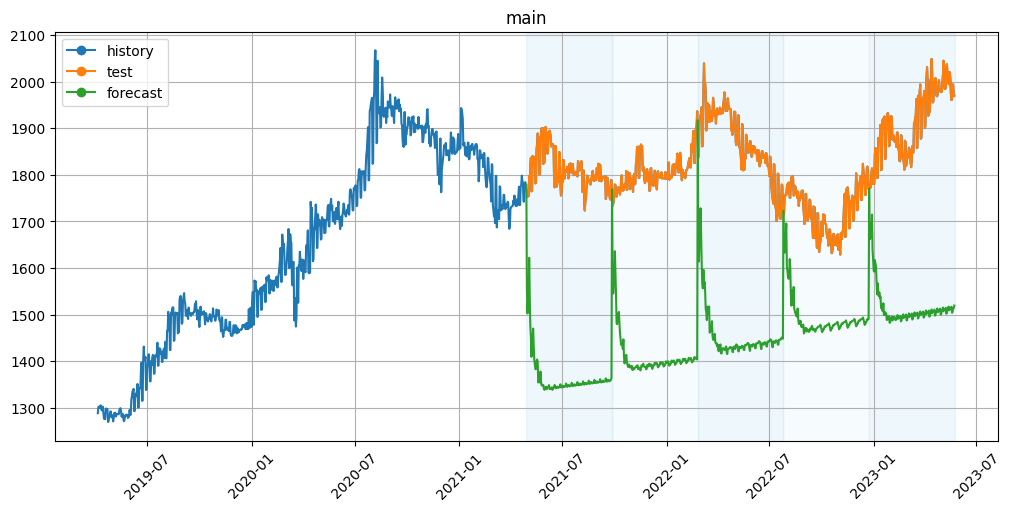

In [ ]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

In [ ]:
autoregressive_pipeline_metrics

SMAPE           22.888293
MAE            374.619069
MAPE            20.379939
fold_number      2.000000
dtype: float64

Пока качество ужасное. Попробуем еще поиграться с дополнительными параметрами

In [ ]:
model = CatBoostPerSegmentModel()

transforms = [
    LogTransform(in_column="target"), # логарифмируем таргет, чтобы сделать ряд более стационарным (разброс становится равномерным)
    LinearTrendTransform(in_column="target"), # достаем компоненту тренда
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    MeanTransform(in_column="target", window=30, out_column="target_mean")
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=3
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

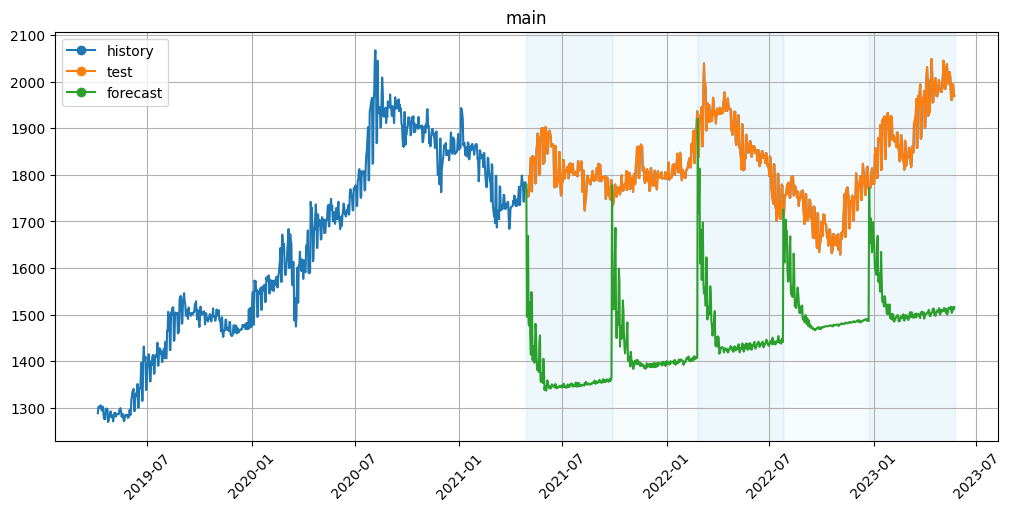

In [ ]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

In [ ]:
autoregressive_pipeline_metrics

SMAPE           22.510486
MAE            368.838364
MAPE            20.059146
fold_number      2.000000
dtype: float64

Модель уловила непонятную сезонность и из-за этого предикт очень некачественный. Попробуем добавить stl разложение на основе аримы, чтобы исправить это.

> ARIMA (autoregressive integrated moving average) - авторегрессионное интегрированное скользящее среднее  является обобщением модели авторегрессионного скользящего среднего. Обычно модель упоминается, как ARIMA(p,d,q), где p,d и q — целые неотрицательные числа, характеризующие порядок для частей модели (соответственно авторегрессионной, интегрированной и скользящего среднего) [4]

идея моделей семейства ARIMA: приведение ряда к стационарному и применение регрессии

In [ ]:
model = CatBoostPerSegmentModel()

transforms = [
    LogTransform(in_column="target"), # логарифмируем таргет, чтобы сделать ряд более стационарным (разброс становится равномерным)
    LinearTrendTransform(in_column="target"), # достаем компоненту тренда
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    MeanTransform(in_column="target", window=30, out_column="target_mean"),
    STLTransform(in_column="target", period=100, model="arima")
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=5
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

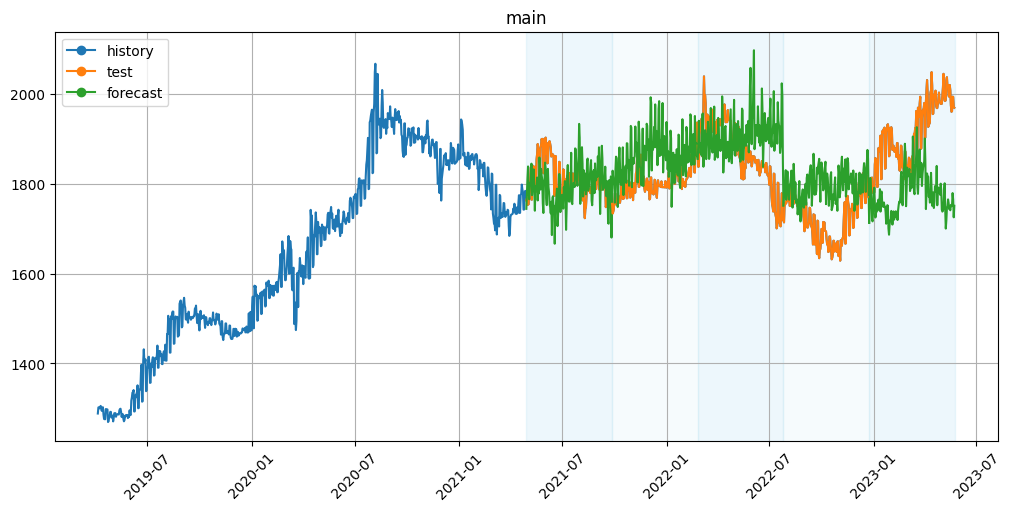

In [ ]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

In [ ]:
autoregressive_pipeline_metrics

SMAPE           4.521750
MAE            82.832771
MAPE            4.515499
fold_number     2.000000
dtype: float64

Получены неплохие результаты, хотя чем дальше предсказание тем сильнее ошибается модель. Это связано с тем, что в указанной архитектуре мы используем предсказанные значения как признаки и как следствие ошибка сдвигается. Попробуем применить другую архитектуру, основанную на той же модели


---



---


`Pipeline` реализует версию прямой стратегии, при которой всего одна модель обучается предсказывать все будущие значения. Это подразумевают следующее:

Плюсы:
* Самый быстрый метод - как на обучении, так и на инференсе

Минусы:

* `Pipeline` не позволяет использовать лаги со значениями меньше параметра `horizon`
* При использовании лагов может начать терять в качестве при увеличении горизонта, так как вслед за этим возрастает ограничение снизу на длину лагов

In [ ]:
model = CatBoostPerSegmentModel()
transforms = [
    LogTransform(in_column="target"), # логарифмируем таргет, чтобы сделать ряд более стационарным (разброс становится равномерным)
    LinearTrendTransform(in_column="target"), # достаем компоненту тренда
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + NUMBER_OF_LAGS)),
        out_column="target_lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    MeanTransform(in_column="target", window=30, out_column="target_mean"),
    STLTransform(in_column="target", period=100, model="arima")
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

pipeline_metrics = metrics_pipeline_df.mean()

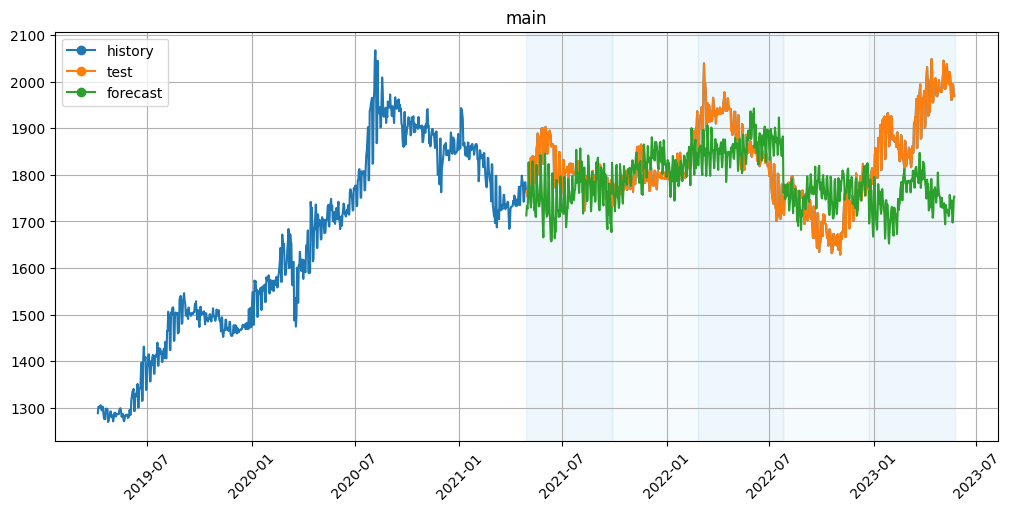

In [ ]:
plot_backtest(forecast_pipeline_df, ts, history_len=HISTORY_LEN)

In [ ]:
pipeline_metrics

SMAPE           4.259005
MAE            77.348891
MAPE            4.165146
fold_number     2.000000
dtype: float64

Получилось даже чуть лучше чем в авторегресси (если смотреть на MAE).

Теперь построим предсказание на будущее

In [ ]:
from etna.datasets import generate_const_df
dt = generate_const_df(periods=151, start_time="2023-06-01", n_segments=1, scale=1)
dt.segment = 'main'
df_ts_format = TSDataset.to_dataset(dt)
pr_ts = TSDataset(df_ts_format, "D")

In [ ]:
pr_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2023-06-01    2023-10-29     151            0


In [ ]:
pipeline.fit(ts)

Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [151, 152, 153, 154, 155, 156, 157, 158, 159, 160], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flag', ), MeanTransform(in_column = 'target', window = 30, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'target_mean', ), STLTransform(in_column = 'target', period = 100, model = 'arima', robust =

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:277: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


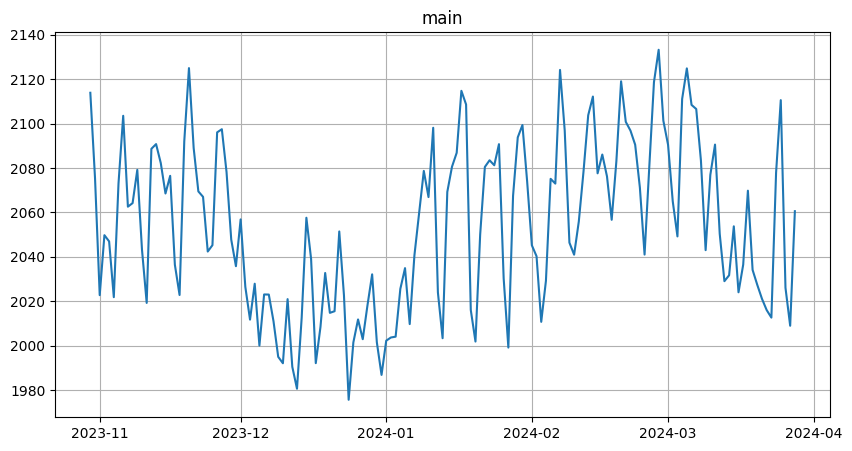

In [ ]:
pipeline.forecast(pr_ts).plot()

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:277: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


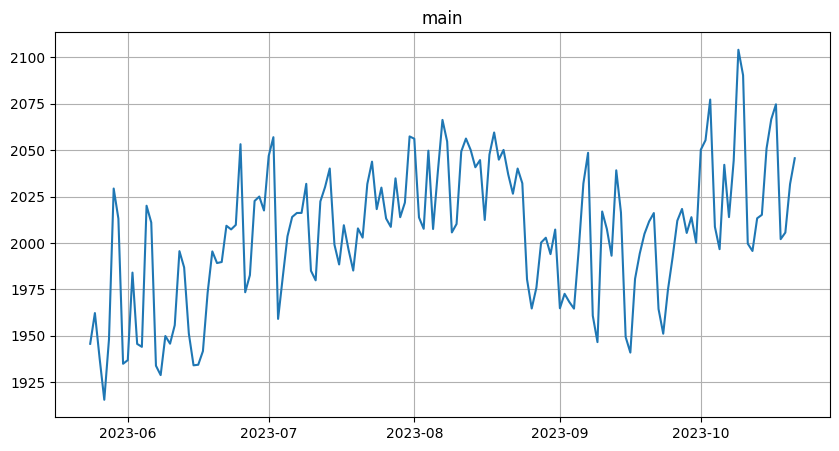

In [ ]:
pipeline.forecast(ts).plot()